In [13]:
from pymongo import MongoClient
# import matplotlib as plt
import matplotlib.pyplot as plt
import pandas as pd
import json
from datetime import datetime
import numpy as np
from datetime import datetime,timedelta
import time
import collections
from itertools import izip, count
import math

In [14]:
# 3. Lets define some use-case specific UDF(User Defined Functions)

def moving_average(data, window_size):
#     """ Computes moving average using discrete linear convolution of two one dimensional sequences.
#     Args:
#     -----
#             data (pandas.Series): independent variable
#             window_size (int): rolling window size

#     Returns:
#     --------
#             ndarray of linear convolution

#     References:
#     ------------
#     [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
#     [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

#     """
    window = np.ones(int(window_size))/float(window_size)
#     print window
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
#   """ Helps in exploring the anamolies using stationary standard deviation
#     Args:
#     -----
#         y (pandas.Series): independent variable
#         window_size (int): rolling window size
#         sigma (int): value for standard deviation
#     Returns:
#     --------
#         a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
#         containing information about the points indentified as anomalies
#     """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in izip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
#     """ Helps in exploring the anamolies using rolling standard deviation
#     Args:
#     -----
#         y (pandas.Series): independent variable
#         window_size (int): rolling window size
#         sigma (int): value for standard deviation
#     Returns:
#     --------
#         a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
#         containing information about the points indentified as anomalies
#     """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in izip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, title, sigma_value=1, 
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False, start=1, end=2):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
#     plt.xlim(3500, 4500)
#     plt.ylim(70,100)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)
    

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)
    plt.title(title)
    plt.plot(720,100,"y*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

In [15]:
client = MongoClient()
client = MongoClient('127.0.0.1', 27017)
db = client['fusheng']
collection = db['data_v3']

In [16]:
def data_handler(list_a, alert_timestamp, offset, collection, diff_time=14400, date_offset='date_offset', value='AE_TEMPERATURE'):
    offset = itv_min * 60
    start = str(alert_timestamp-offset)
    end = str(alert_timestamp+offset)
    def time_fix(x):
        start_time = alert_timestamp - offset + diff_time
        return (float(time.mktime(datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timetuple()))-int(start_time))/5
    list_a = []
    for a in collection.find({"timestamp": {"$gt": start,"$lte": end}}):
        del a['_id']
        list_a.append(a)
    print len(list_a)
    
    start_time = alert_timestamp - offset + diff_time

    df = pd.DataFrame(list_a)
    ts = df.sort_values(date_offset)
    ts1 = ts[ts.date_offset.notnull()]
    df2 = ts1[[date_offset,value]]
    df2[date_offset] = df2[date_offset].apply(lambda x: time_fix(x))
    df2[value] = df2[value].apply(lambda x: math.pow(float(x), 1))
    df2 = df2[df2[value].notnull()]
    return df2

def visualize(df2, alert_time, size=5, sigma=2, date_offset='date_offset', value='AE_TEMPERATURE'):
    x = df2[date_offset]
    Y = df2[value].apply(lambda x: float(x))

    # plot the results
    plot_results(x, y=Y, window_size=size, text_xlabel="time", sigma_value=sigma, text_ylabel=value, title=alert_time)
    events = explain_anomalies(Y, window_size=size, sigma=sigma)

    # Display the anomaly dict
    print("Information about the anomalies model:{}".format(events))

1456


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


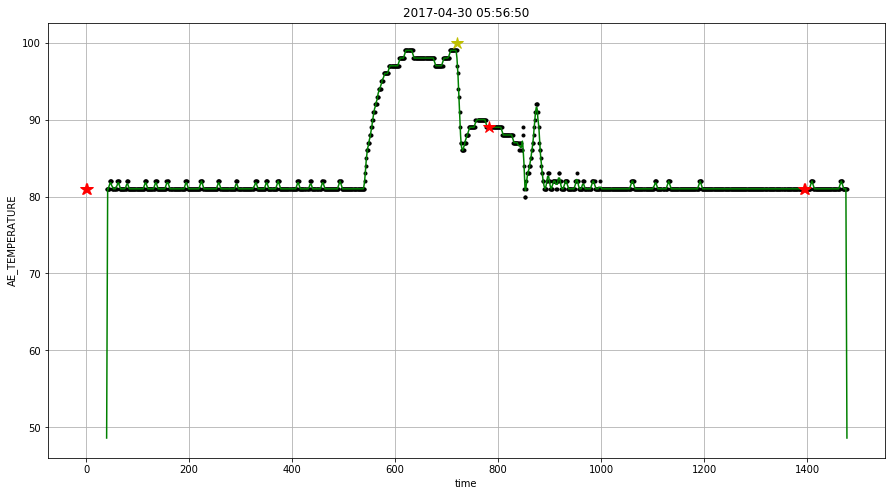

Information about the anomalies model:{'anomalies_dict': OrderedDict([(0, 81.0), (1, 81.0), (783, 89.0), (1394, 81.0), (1395, 81.0)]), 'standard_deviation': 1.387}
1456


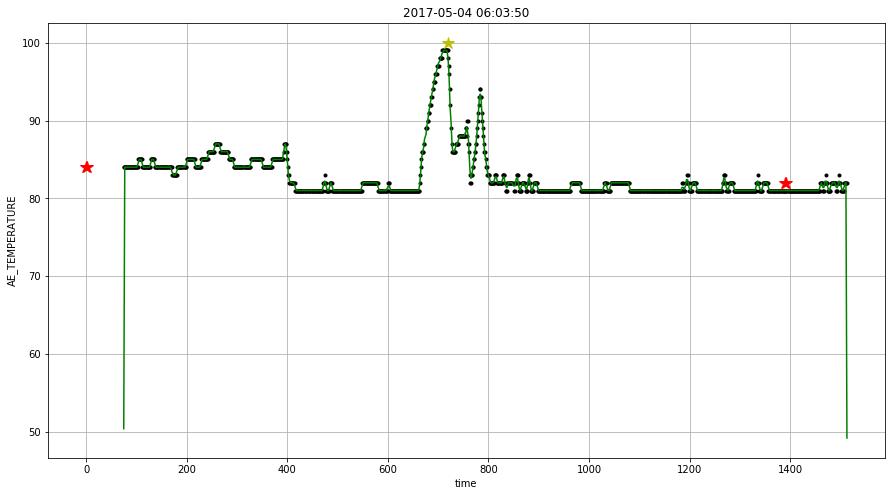

Information about the anomalies model:{'anomalies_dict': OrderedDict([(0, 84.0), (1, 84.0), (1390, 82.0), (1391, 82.0)]), 'standard_deviation': 1.42}
1456


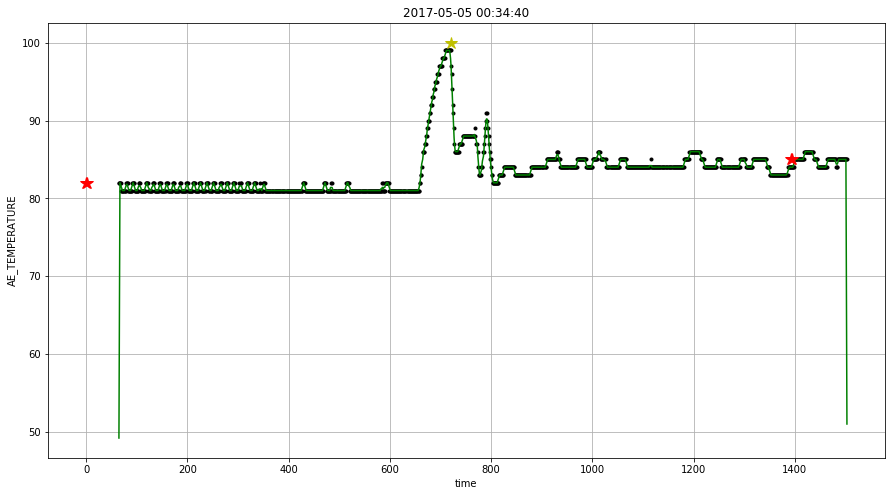

Information about the anomalies model:{'anomalies_dict': OrderedDict([(0, 82.0), (1, 82.0), (1393, 85.0), (1394, 85.0)]), 'standard_deviation': 1.427}
1456


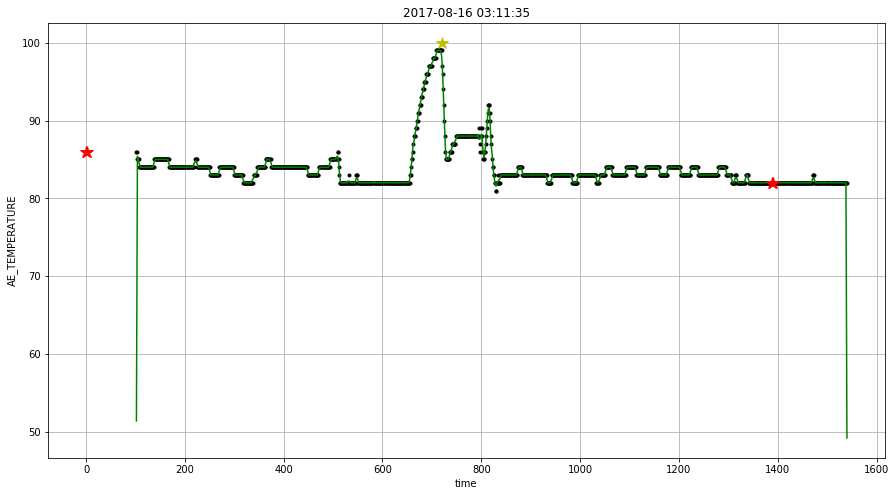

Information about the anomalies model:{'anomalies_dict': OrderedDict([(0, 86.0), (1, 86.0), (1389, 82.0), (1390, 82.0)]), 'standard_deviation': 1.441}
1456


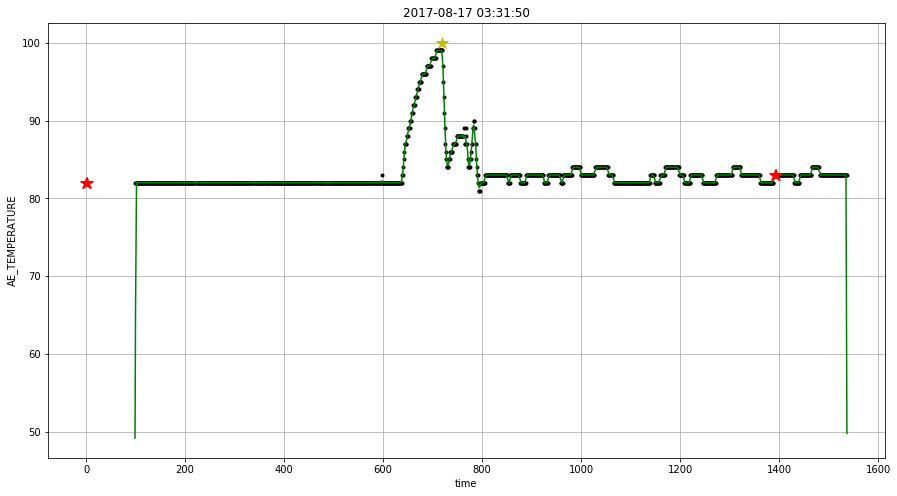

Information about the anomalies model:{'anomalies_dict': OrderedDict([(0, 82.0), (1, 82.0), (1392, 83.0), (1393, 83.0)]), 'standard_deviation': 1.405}


In [17]:
itv_min = 60
# TSA150019A alert
# alert_time = "2017-07-20 02:30:25"
# alert_time = "2017-07-22 02:17:00"
# alert_time = "2017-08-15 03:20:45"
# alert_time = "2017-08-16 03:05:40"
# alert_time = "2017-08-17 03:24:40"
# alert_time = "2017-08-18 02:56:55"

# TSC100081 alert
# alert_time = "2017-04-30 05:56:50"
# alert_time = "2017-05-04 06:03:50"
# alert_time = "2017-05-05 00:34:40"
# alert_time = "2017-08-16 03:11:35"
# alert_time = "2017-08-17 03:31:50"

alert_list = ["2017-04-30 05:56:50",
             "2017-05-04 06:03:50",
             "2017-05-05 00:34:40",
             "2017-08-16 03:11:35",
             "2017-08-17 03:31:50",
             ]
    
value='AE_TEMPERATURE'
# value='HS_VSD_OUT_HZ'
# value = 'DISCHARGE_PRESSURE'
# value = 'INTPUT_Current'
# value = 'SYSTEM_PRESSURE'
# value = 'HS_OVERALL_KW'
# value = 'RUNNING'
# value = 'SV_SOURCE'

a = []
b = "date_offset"

for alert_time in alert_list:
    alert_timestamp = time.mktime(datetime.strptime(alert_time, "%Y-%m-%d %H:%M:%S").timetuple()) - 14400
    df2 = data_handler(a, alert_timestamp, b, collection, value=value)
    visualize(df2, alert_time, value=value)

In [18]:
# 2017-10-24 code

# diff_time = 14400
# alert_timestamp = time.mktime(datetime.strptime(alert_time, "%Y-%m-%d %H:%M:%S").timetuple()) - diff_time
# offset = itv_min*60
# start = str(alert_timestamp-offset)
# end = str(alert_timestamp+offset)

# list_a = []
# for a in collection.find({"timestamp": {"$gt": start,"$lte": end}}):
#     del a['_id']
#     list_a.append(a)
# print len(list_a)



# 2017-10-24 code

# start_time = alert_timestamp - offset + diff_time
# df = pd.DataFrame(list_a)
# ts = df.sort_values('date_offset')
# ts1 = ts[ts.date_offset.notnull()]
# # df1 = pd.DataFrame(list(ts1["AE_TEMPERATURE"]),index=ts1["date_offset"])
# df2 = ts1[["date_offset","AE_TEMPERATURE"]]
# df2["date_offset"] = df2["date_offset"].apply(lambda x: 
#                                               (float(time.mktime(datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timetuple()))-int(start_time))/5)
# df2["AE_TEMPERATURE"] = df2["AE_TEMPERATURE"].apply(lambda x: math.pow(float(x), 1))
# df2 = df2[df2.AE_TEMPERATURE.notnull()]


# print df2.head(10)
# print len(df2)
# print  ts1[["date_offset","AE_TEMPERATURE"]]
# print  ts1
# print ts[["date_offset","AE_TEMPERATURE"]].head(10)




# 2017-10-24 code

# x = df2['date_offset']
# Y = df2['AE_TEMPERATURE'].apply(lambda x: float(x))
# size=5
# sigma=2
# # plot the results
# plot_results(x, y=Y, window_size=size, text_xlabel="time", sigma_value=sigma,
#              text_ylabel="AE_TEMPERATURE")
# events = explain_anomalies(Y, window_size=size, sigma=sigma)
# # Display the anomaly dict
# print("Information about the anomalies model:{}".format(events))